### We import packages and some data.

In [44]:
# Importing packages

import MilneEddington as ME
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
from matplotlib.ticker import LogLocator
import pandas as pd
from tabulate import tabulate
from mpl_toolkits.mplot3d import Axes3D

In [45]:
stokes = fits.open('hinode_data.fits')[0].data[:,:512]
print(stokes.shape)
hc = fits.open('convolved_hinode.fits')[0].data[:,:128]
print(hc.shape)

(512, 512, 4, 112)
(128, 128, 4, 112)


In [47]:
mean1 = np.mean(hc[:, :, 0, :10])
hc = hc.copy()  
hc = hc.astype(np.float64)
hc /= mean1

In [51]:
mean2 = np.mean(stokes[:, :, 0, :10])
stokes = stokes.copy()  
stokes = stokes.astype(np.float64)
stokes /= mean2

In [49]:
print(mean1, mean2)

1.0 17239.684487915038


### Here, we work with the South Pole of the Sun.

ValueError: num must be an integer with 1 <= num <= 1, not 2

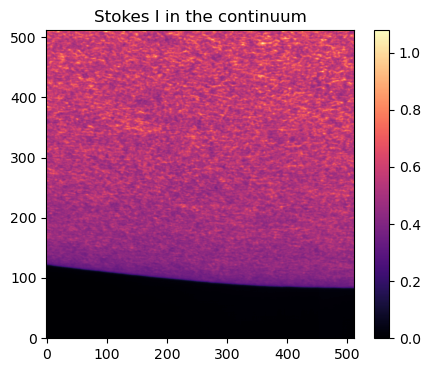

In [50]:
plt.figure(figsize=(11, 4))

plt.subplot(1, 2, 1)
#plt.grid()
plt.imshow(stokes[:, :, 0, 28], cmap='magma', origin='lower')
plt.colorbar()
plt.title(r'Stokes I in the continuum')

plt.subplot(1, 1, 2)
plt.imshow(hc[:, :, 0, 28], origin='lower', cmap='magma')
#plt.grid()
plt.colorbar()
plt.title(r'Stokes I in the continuum (convolved)')

plt.show()

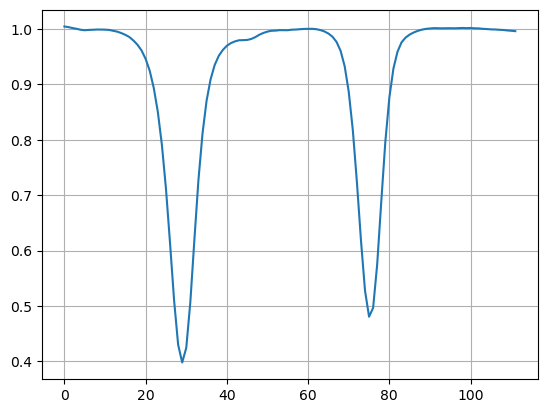

In [7]:
mean_spectrum = np.mean(hc, axis = (0, 1))
plt.grid()
plt.plot(mean_spectrum[0])
plt.show()

### PSF used for convolution is shown below.

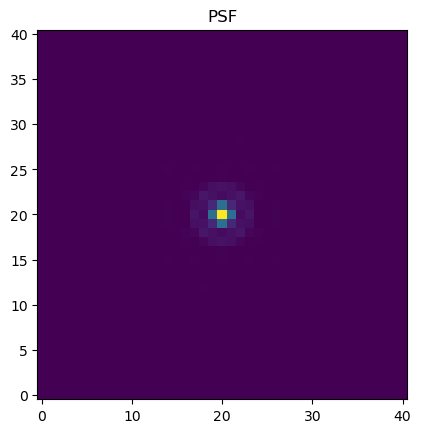

In [57]:
psf = fits.open('hinode_psf_0.16.fits')[0].data
plt.imshow(psf, origin='lower')
plt.title('PSF')
plt.show()

### Quick example - inversion for one pixel.

In [10]:
ll = np.linspace(6301, 6303, 112)
i = 120
j = 120

regions = [[ll, None]]
lines = [6301, 6302]

me = ME.MilneEddington(regions, lines, nthreads=2)

nx = 1
ny = 1

model_guess = np.float64([1000., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0])
models_guess  = me.repeat_model(model_guess, nx, ny)
to_fit = hc[i, j, :, :].reshape(1, 1, 4, 112)
model_out, syn_out, chi2 = me.invert(models_guess, to_fit,  nRandom = 20, nIter = 100, chi2_thres = 1.0, verbose = False)

print ('B:', model_out[0,0,0]) 
print ('inc:', model_out[0,0,1]*180./np.pi) 
print ('azi:', model_out[0,0,2]*180./np.pi) 
print ('v:', model_out[0,0,3]) 
print ('Chi-squared = ',chi2) 

pyMilne::dealloc: cleaning-up...
B: 1842.0136077282025
inc: 89.14432283943759
azi: 49.63457380220444
v: -0.500486868397799
Chi-squared =  [[6770.64411624]]


line::line: Initialized [6301.499500] ->  12 Zeeman components
line::line: Initialized [6302.493100] ->   3 Zeeman components
InvertMany: Processed -> 100%


### Now, we import data we got from regular inversion procedure.

In [6]:
mpp = fits.open('piksel.fits')[0].data # pixel-to-pixel
msc = fits.open('sc_00.fits')[0].data # spatially-coupled

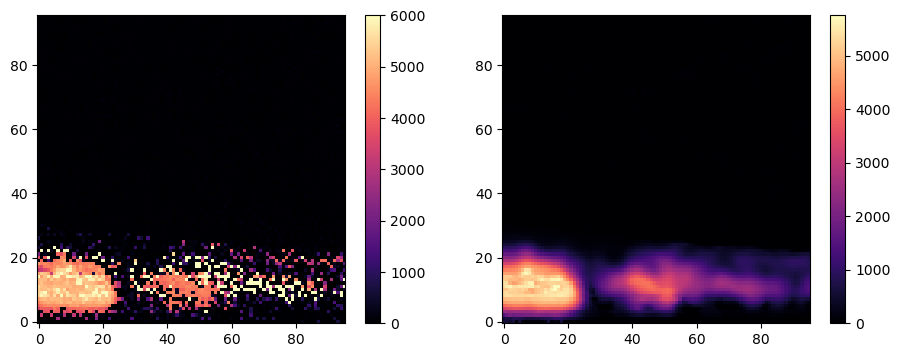

In [12]:
plt.figure(figsize=(11, 4))

plt.subplot(1, 2, 1)
plt.imshow(mpp[:,:,0], origin='lower', cmap='magma')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(msc[:,:,0], origin='lower', cmap='magma')
plt.colorbar()

plt.show()

### Here, we determine parameters in order to calculate various things.

In [13]:
B = msc[:, :, 0] # magnetic field
theta = msc[:, :, 1]  # inclination angle in radians
phi = msc[:, :, 2]    # azimuth angle in radians

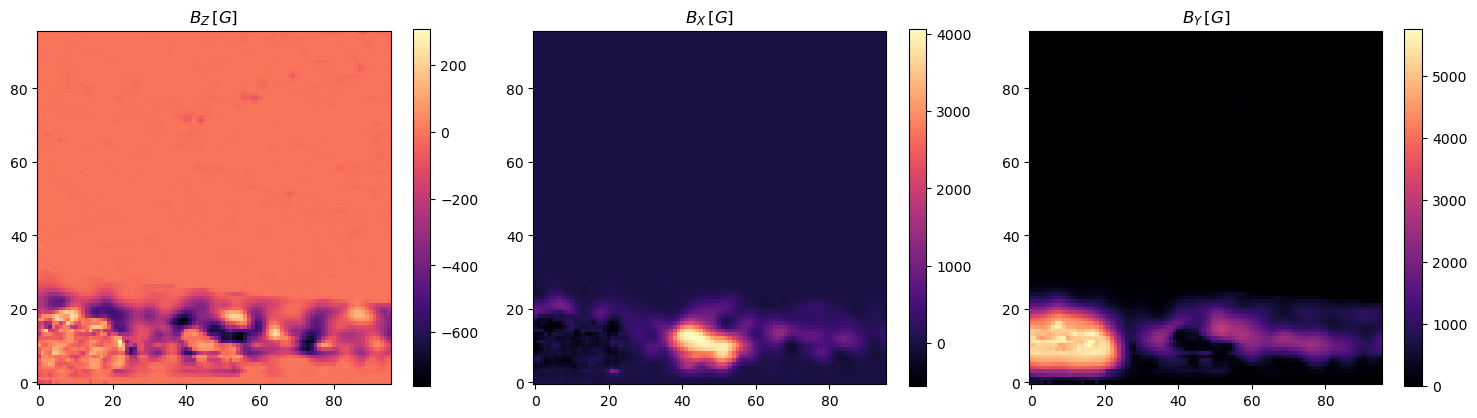

In [14]:
# Calculating the vertical and horizontal components of magnetic field
B_z = B * np.cos(theta)
B_x = B * np.sin(theta) * np.cos(phi)
B_y = B * np.sin(theta) * np.sin(phi)

# Plot the components
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(B_z, origin='lower', cmap='magma')
plt.colorbar()
plt.title(r'$B_Z\,[G]$')

plt.subplot(1, 3, 2)
plt.imshow(B_x, origin='lower', cmap='magma')
plt.colorbar()
plt.title(r'$B_X\,[G]$')

plt.subplot(1, 3, 3)
plt.imshow(B_y, origin='lower', cmap='magma')
plt.colorbar()
plt.title(r'$B_Y\,[G]$')

plt.tight_layout()
plt.show()

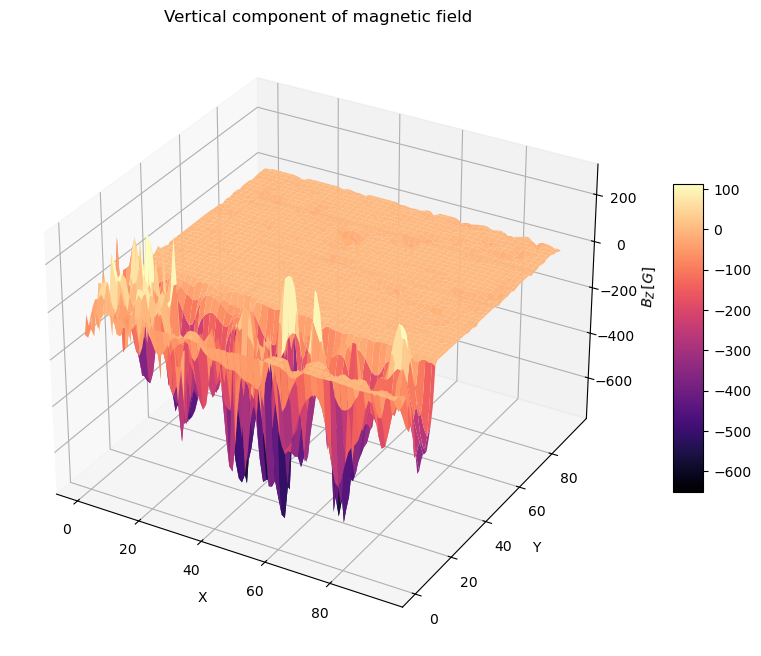

In [14]:
# Vertical component of magentic field

x = np.arange(B.shape[0])
y = np.arange(B.shape[1])
x, y = np.meshgrid(x, y)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, B_z, cmap='magma')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel(r'$B_Z\,[G]$')
ax.set_title('Vertical component of magnetic field')

plt.show()

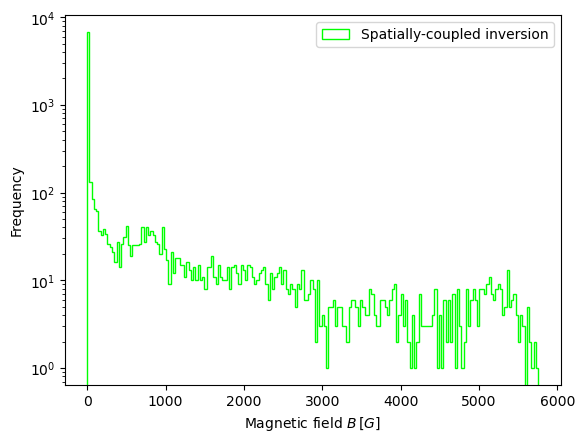

In [16]:
num_bins = 200 

plt.hist(B.ravel(), bins=num_bins, color='lime',
         label='Spatially-coupled inversion', histtype='step')

#plt.title(r'Inversions - comparison for magnetic field')
plt.xlabel(r'Magnetic field $B\,[G]$')
plt.ylabel(r'Frequency')

# Set the y-axis to a logarithmic scale
plt.yscale('log')
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0))

plt.legend()
plt.grid(False)
plt.show()

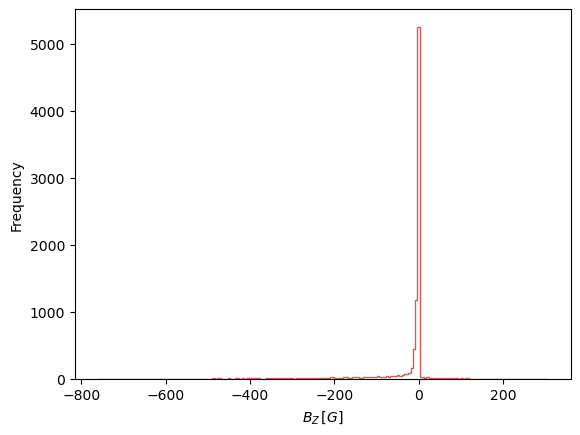

In [17]:
num_bins = 200

plt.hist(B_z.ravel(), bins=num_bins, color='indianred', histtype='step')

plt.xlabel(r'$B_Z\,[G]$')
plt.ylabel(r'Frequency')

# Set the y-axis to a logarithmic scale
#plt.yscale('log')
#plt.gca().yaxis.set_major_locator(LogLocator(base=10.0))

plt.grid(False)
plt.show()

/home/zorzeus/anaconda3/envs/mil/lib/python3.12/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/zorzeus/anaconda3/envs/mil/lib/python3.12/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


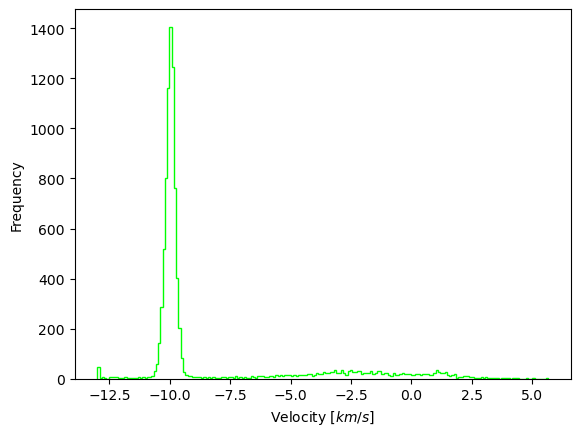

In [7]:
num_bins = 200 

plt.hist(msc[:, :, 3].ravel(), bins=num_bins, color='lime', histtype='step')

#plt.title(r'Inversions - comparison for magnetic field')
plt.xlabel(r'Velocity $[km/s]$')
plt.ylabel(r'Frequency')

# Set the y-axis to a logarithmic scale
#plt.yscale('log')
#plt.gca().yaxis.set_major_locator(LogLocator(base=10.0))

plt.grid(False)
plt.show()

### We make assumption that the magnetic field vector is either vertical or horizontal
### to the local surface (or undetermined). 

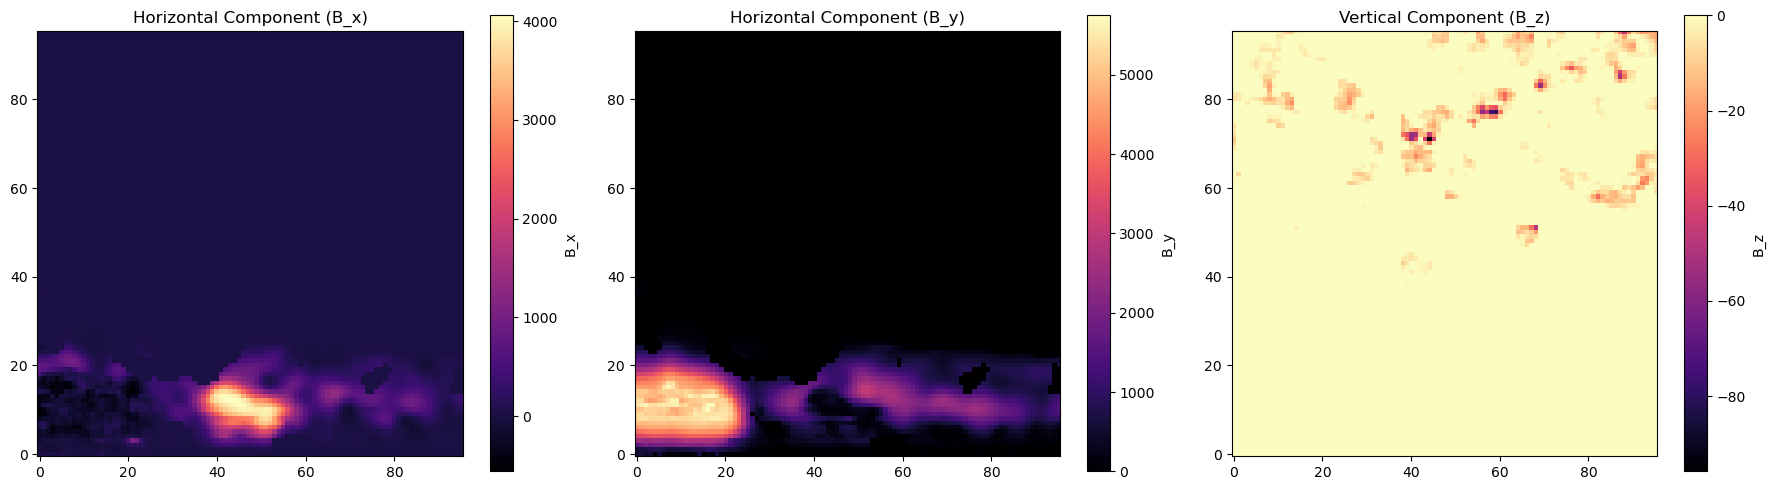

In [12]:
# Extract the magnetic field magnitude, inclination angle, and azimuth angle
B = msc[:, :, 0]
gamma = msc[:, :, 1]  # inclination angle in radians
chi = msc[:, :, 2]    # azimuth angle in radians

# Convert heliocentric coordinates from arcseconds to radians
XCEN_arcsec = -50.2884191439
YCEN_arcsec = -61.7706628990

# Convert arcseconds to degrees
XCEN_degrees = XCEN_arcsec / 3600.0
YCEN_degrees = YCEN_arcsec / 3600.0

# Convert degrees to radians
delta = np.radians(YCEN_degrees)  # Helio latitude in radians
phi = np.radians(XCEN_degrees)    # Helio longitude in radians

# Calculate θ and β
theta = np.arccos(np.cos(delta) * np.cos(phi))
beta = np.arccos(np.cos(delta) * np.sin(phi) / np.sin(theta))

# Calculate i1 and i2
i1 = np.arccos(np.cos(gamma) * np.cos(theta) + np.sin(gamma) * np.sin(theta) * np.cos(beta - chi))
i2 = np.arccos(np.cos(gamma) * np.cos(theta) + np.sin(gamma) * np.sin(theta) * np.cos(np.pi - (beta - chi)))

# Create masks based on zenith angles
vertical_mask = ((i1 >= 0) & (i1 <= np.radians(40))) | ((i1 >= np.radians(140)) & (i1 <= np.radians(180)))
horizontal_mask = (i1 >= np.radians(70)) & (i1 <= np.radians(110))

# Extract B_x, B_y, and B_z components from the FITS file
B_x = B * np.sin(gamma) * np.cos(chi)
B_y = B * np.sin(gamma) * np.sin(chi)
B_z = B * np.cos(gamma)

# Set components to zero where the inclination angle does not meet the criteria
B_x_filtered = np.where(horizontal_mask, B_x, 0)
B_y_filtered = np.where(horizontal_mask, B_y, 0)
B_z_filtered = np.where(vertical_mask, B_z, 0)

# Create a grid for the x and y positions
x = np.arange(B.shape[0])
y = np.arange(B.shape[1])
x, y = np.meshgrid(x, y)

# Plot B_x, B_y, and B_z
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.imshow(B_x_filtered, origin='lower', cmap='magma')
plt.colorbar(label='B_x')
plt.title('Horizontal Component (B_x)')

plt.subplot(1, 3, 2)
plt.imshow(B_y_filtered, origin='lower', cmap='magma')
plt.colorbar(label='B_y')
plt.title('Horizontal Component (B_y)')

plt.subplot(1, 3, 3)
plt.imshow(B_z_filtered, origin='lower', cmap='magma')
plt.colorbar(label='B_z')
plt.title('Vertical Component (B_z)')

plt.tight_layout()
plt.show()

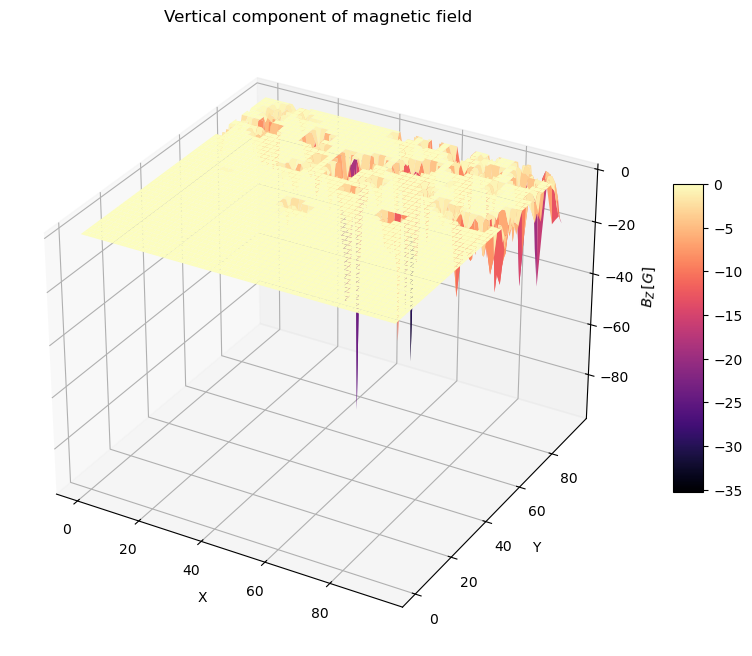

In [13]:
# Vertical component of magentic field

x = np.arange(B_x_filtered.shape[0])
y = np.arange(B_y_filtered.shape[1])
x, y = np.meshgrid(x, y)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, B_z_filtered, cmap='magma')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel(r'$B_Z\,[G]$')
ax.set_title('Vertical component of magnetic field')

plt.show()